In [2]:
import numpy as np 
import celerite
from celerite import terms
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Plot the log-likelihood space for Celerite ... 

In [2]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag

def sampling(tau_in = 100, length=10, t_min=1, dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        t = np.arange(t_min, t_max, dt)
    else :
        # random sampling with the chosen number of points ... 
        # The input coordinates must be sorted
        if verbose: 
            print('Using random sampling')
        Npts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, Npts)) 
        
    return t


In [3]:
# Make a todays dir to save the figure ...
import os 
import datetime

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-11-08/


[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]


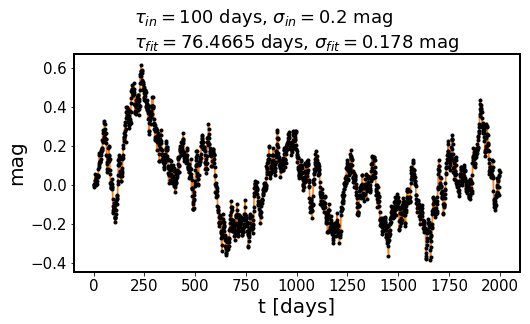

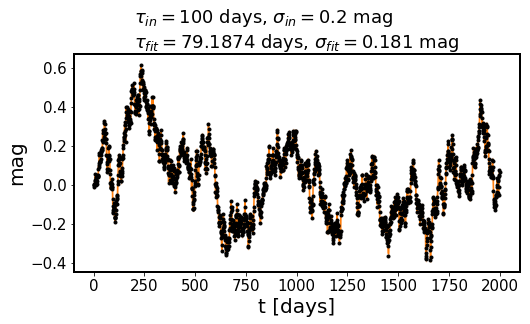

In [31]:
%matplotlib inline

# Simulate a DRW lightcurve and fit with celerite 
tau_in = 100
sigma_in = 0.2
SF_inf = sigma_in * np.sqrt(2)
yerr =  0.001 
#  length = 20 tau,  delta_time = 1 day 
t = sampling(tau_in = tau_in, length=20, regular=True, dt=1)
# we add the Gaussian noise with st.dev = yerr 
noise = np.random.normal(loc=0.0, scale=yerr, size=len(t))
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0) + noise 
    
# fitting procedure : 

# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# optimization of the results 

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]
logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]
#bounds = gp.get_parameter_bounds()
print(bounds)

initial_params = gp.get_parameter_vector()

for prior in ['Jeff1', 'flat'] : 
    if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            return -gp.log_likelihood(y) + (log_a / 2.0) - log_c    
    if prior is 'flat' : 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)

    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])

    # plot the prediction
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    ax.plot(x, pred_mean, color=color)
    ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax.set_xlabel('t [days]')
    ax.set_ylabel('mag')

    title = r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
    r'$\sigma_{in}=$'+str(sigma_in)+' mag'+'\n'\
           +r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
        r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag'

    ax.set_title(title,multialignment='left')
    plt.savefig(outDir+'sim_lc_'+prior+'_prior_fit.png', bbox_inches='tight')

sim_lc = {'y':y, 't':t}
np.save( outDir+'sim_lc_y_t', sim_lc)

In [21]:
outDir

NameError: name 'outDir' is not defined

In [6]:
from astropy.table import Table
# Read in one of the light curves that we fit ....
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
i=0
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
t,y,yerr = lc['time'], lc['mag'], lc['err']

In [95]:
files[0]

'DRWtestCeleriteZI_LC513.dat'

In [69]:
#Use exactly that light curve as above to make the figuere ... 
#sim_lc = np.load(outDir + 'sim_lc_y_t.npy').item()
#y = sim_lc['y']
#t = sim_lc['t']

# initialize the kernel ... 
sigma_in = 0.2
tau_in =  100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in), 
                        log_c = np.log(1/tau_in))

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# Evaluate the log-likelihood manually on a grid of two parameters...
N = 100
# span the grid : truth is tau=100, sigma=0.2
tau_grid = np.linspace(10,300,N)
sigma_grid = np.linspace(0.1, 0.4, N)
# re-express it as logs since that's what goes into fitting 
log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)

# initialize as empty array

loglike_dic = {}
for prior in ['Jeff1','flat','p1', 'p2', 'Jeff2']: # ,  
    print('Calculating the negloglike grid for %s prior'%prior)
    loglike = np.zeros([N,N], dtype=float)
    for i in range(len(log_a_grid)):
        for j in range(len(log_c_grid)):
            params = [log_a_grid[i],log_c_grid[j]]
            if prior is 'p1' : # sigma*tau
                def neg_log_like(params,y,gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y) - (log_a / 2.0) + log_c

            if prior is 'p2' : # sigma_hat * tau 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )

            if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
                def neg_log_like(params,y,gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    #print(log_a/2.0,log_c, log_a/2.0 - log_c)
                    #print(-gp.log_likelihood(y))
                    return -gp.log_likelihood(y) + (log_a / 2.0) - log_c

            if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

            if prior is 'flat' : # flat prior 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    return -gp.log_likelihood(y)

            loglike[i,j] = neg_log_like(params,y,gp)
    # store this grid of logike ... 
    loglike_dic[prior] = loglike

print('Done')

Calculating the negloglike grid for Jeff1 prior
Calculating the negloglike grid for flat prior
Calculating the negloglike grid for p1 prior
Calculating the negloglike grid for p2 prior
Calculating the negloglike grid for Jeff2 prior
Done


In [10]:
# For the entire grid,  make alternative maps of NxN  (z-dimension),
# reflecting tau, sigma,  sigma_hat, 
# so that each point on the grid has a value 
# of sigma, tau, sigma_hat,  as well as logL 
z_loglike = loglike
z_tau = np.zeros([N,N] , dtype=float)
z_sigma = np.zeros([N,N], dtype=float)
z_sigma_hat = np.zeros([N,N], dtype=float)
z_K = np.zeros([N,N], dtype=float)
for i in range(len(sigma_grid)):
    for j in range(len(tau_grid)):
        z_tau[i,j] = tau_grid[j]
        z_sigma[i,j] = sigma_grid[i]
        z_sigma_hat[i,j] = sigma_grid[i] * np.sqrt(2 / tau_grid[j])
        z_K[i,j] = tau_grid[j] * np.sqrt(sigma_grid[i]) * np.power(2, 0.25)

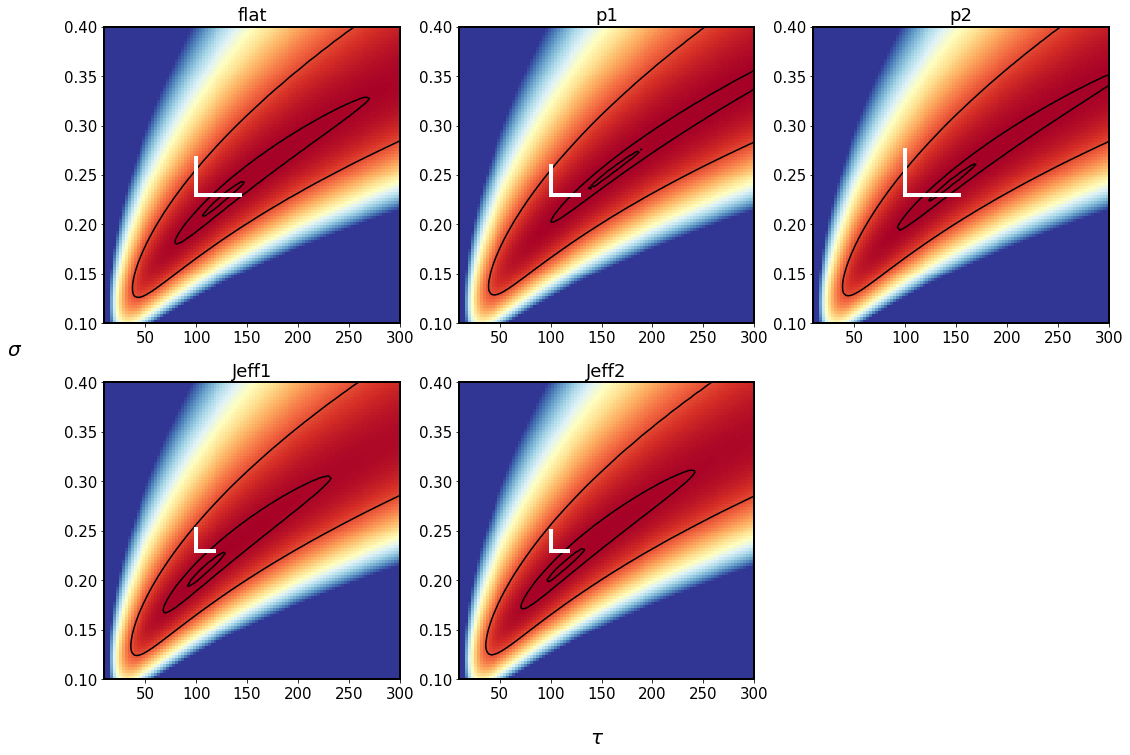

In [147]:
# Plot the posterior pdf based on each prior... 

from matplotlib import ticker
fig,axs = plt.subplots(2,3, figsize=(18,12))
ax = np.ravel(axs)
i =0 
for prior in ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']:
    #z = loglike_dic[prior] / 500
    
    # attempt to normalize....
    x = loglike_dic[prior]
    shift = x-min(np.ravel(x))
    norm = np.sum(shift)
    z = shift / norm
    # so that now np.sum(new) ~ 1 
    im = ax[i].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
                  cmap=plt.cm.get_cmap('RdYlBu'),vmax=0.0001,
                   aspect='auto', origin='lower')
    ax[i].set_title(prior)

    ax[i].contour(tau_grid, sigma_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='k') 
    
    # plot the error ,....
    dy= results[prior]['s_sigma'][i]
    ax[i].plot([100,100],[0.23,0.23+dy], lw=4, c='white')
    dx = results[prior]['s_tau'][i]
    ax[i].plot([100,100+dx],[0.23,0.23], lw=4, c='white')
    i += 1
ax[i].axis('off')
#cax = fig.add_axes([0.57,0.2,0.29,0.02])
#cbar = plt.colorbar(im,cax, orientation='horizontal')
#cbar.set_label(label=r'$log(L)$', color='white')
fig.text(0.5,0.05, r'$\tau$', fontsize=20)
fig.text(0.05,0.5, r'$\sigma$',fontsize=20)
plt.savefig(outDir+'posterior_pdf_all_priors.png', bbox_inches='tight')


In [136]:
fname = 'ZI_fits_results_11-07-17.npy'
simDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/'
results = np.load(simDir+fname).item()

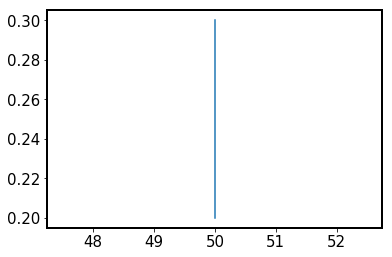

In [144]:
plt.plot([50,50], [0.2,0.3])

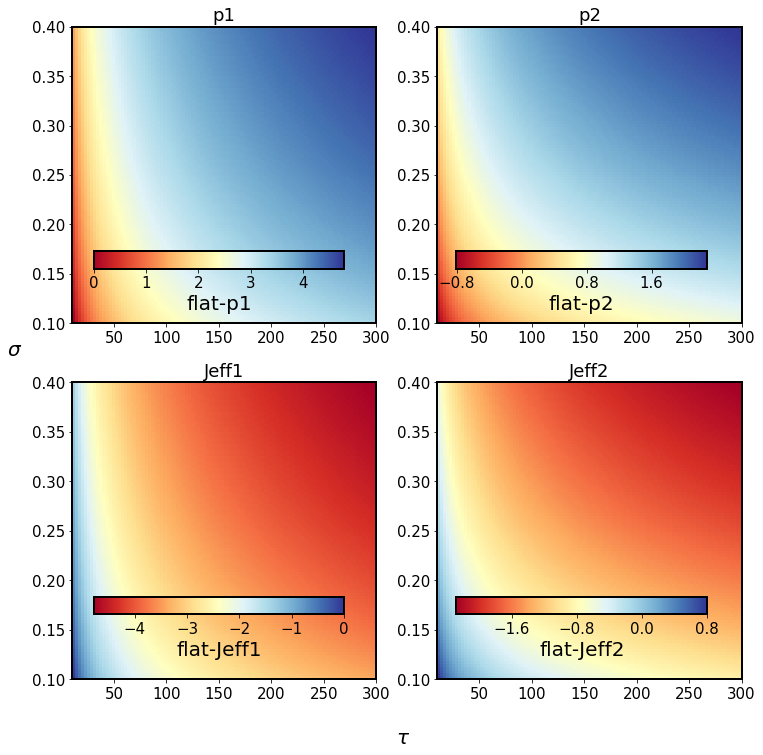

In [94]:
# Plot the residuals of posterior pdf based on flat prior - the other prior... 

from matplotlib import ticker
fig,axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)
i =0 
cax_position = [[0.15,0.6,0.29,0.02],[0.57,0.6,0.29,0.02],
                [0.15,0.2,0.29,0.02],[0.57,0.2,0.29,0.02]
               ]
for prior in ['p1', 'p2', 'Jeff1', 'Jeff2']:
    z = loglike_dic['flat']-loglike_dic[prior]
    im = ax[i].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
                  cmap=plt.cm.get_cmap('RdYlBu'), 
                   aspect='auto', origin='lower')
    ax[i].set_title(prior)
    cax = fig.add_axes(cax_position[i])
    cbar = plt.colorbar(im,cax, orientation='horizontal', 
                    label='flat-'+prior)

    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    i += 1

fig.text(0.5,0.05, r'$\tau$', fontsize=20)
fig.text(0.05,0.5, r'$\sigma$',fontsize=20)
plt.savefig(outDir+'posterior_flat-residuals.png', bbox_inches='tight')

In [87]:
outDir

'/Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-11-08/'

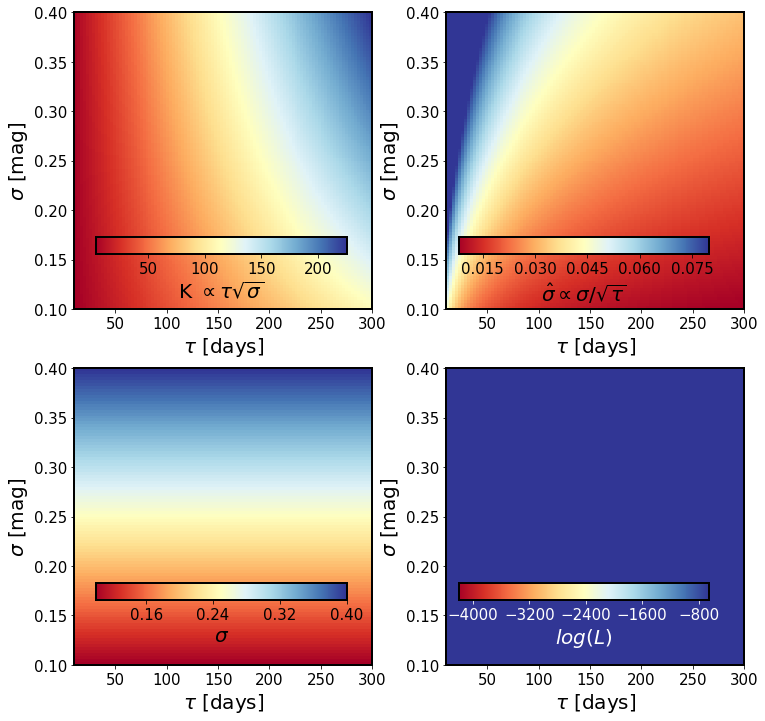

In [12]:
# Plot to show that it worked  : 
# Proof of concept 

fig,ax = plt.subplots(2,2,figsize=(12,12)) #, sharex=True, sharey=True
         
z = z_K
im = ax[0,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label='K '+r'$\propto \tau \sqrt{\sigma}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$ [days]')
        ax[i,j].set_ylabel(r'$\sigma$ [mag]')
        
z = z_sigma_hat
im = ax[0,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=0.08,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\hat{\sigma} \propto \sigma / \sqrt{\tau}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_sigma
im = ax[1,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\sigma$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_loglike
im = ax[1,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=-4200,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal')
cbar.set_label(label=r'$log(L)$', color='white')

from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.tick_params(colors='white')

fig.subplots_adjust(wspace=0.25)
# makes sense
plt.savefig(outDir+'sim_lc_logL_four_panels.png', bbox_inches='tight')

This makes sense, because we would expect that K is the combination of tau, sigma, just like sigma_hat,  and log-likelihood looks just fine as well.... 

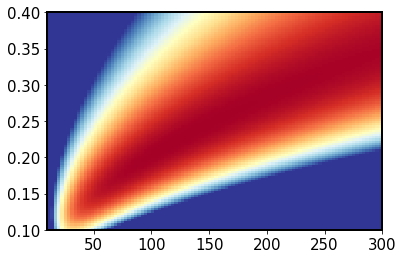

(array([ 7627.,  1317.,   473.,   214.,   136.,    96.,    62.,    41.,
           22.,    12.]),
 array([ -644.71626645,  -478.52185371,  -312.32744096,  -146.13302822,
           20.06138452,   186.25579726,   352.45021001,   518.64462275,
          684.83903549,   851.03344823,  1017.22786098]),
 <a list of 10 Patch objects>)

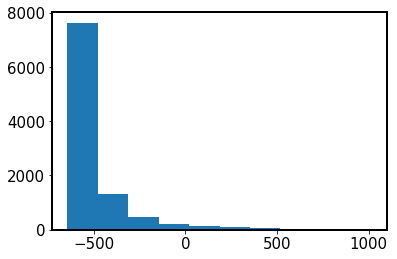

In [32]:
z = z_loglike
plt.hist(z.flatten())

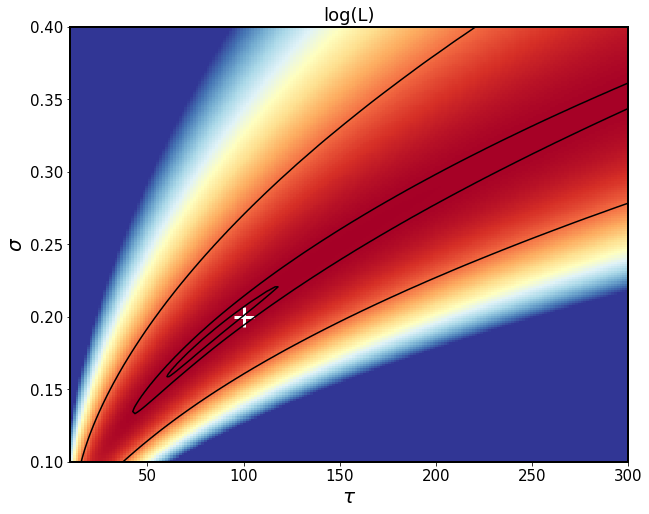

In [61]:
# Plot the loglikelihood and the contours...
# Using imshow 

fig,ax = plt.subplots(figsize=(10,8)) 

z = loglike /4000  # need to scale , otherwise we get too small numbers ... 

im = ax.imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax = -0.9,
               aspect='auto', origin='lower')

ax.contour(tau_grid, sigma_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='k')
ax.scatter(tau_in, sigma_in, marker='+', s=400, lw=3, c='white')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\sigma$')
ax.set_title('log(L)')
plt.savefig(outDir + 'sim_lc_loglike.png', bbox_inches = 'tight')

In [50]:
sigma = np.exp(-loglike)
shape = sigma.shape
sigma = sigma.ravel()

# obtain the indices to sort and unsort the flattened array
i_sort = np.argsort(sigma)[::-1]
i_unsort = np.argsort(i_sort)

sigma_cumsum = sigma[i_sort].cumsum()
sigma_cumsum /= sigma_cumsum[-1]

sigma_cumsum[i_unsort].reshape(shape)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

(array([ 30937.,   4963.,   1840.,    836.,    547.,    368.,    238.,
           154.,     84.,     33.]),
 array([-4263.38871226, -3373.08164622, -2482.77458019, -1592.46751416,
         -702.16044812,   188.14661791,  1078.45368394,  1968.76074998,
         2859.06781601,  3749.37488204,  4639.68194807]),
 <a list of 10 Patch objects>)

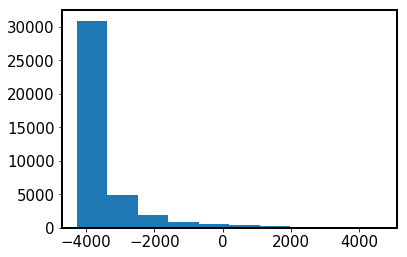

In [85]:
plt.hist(loglike.flatten())

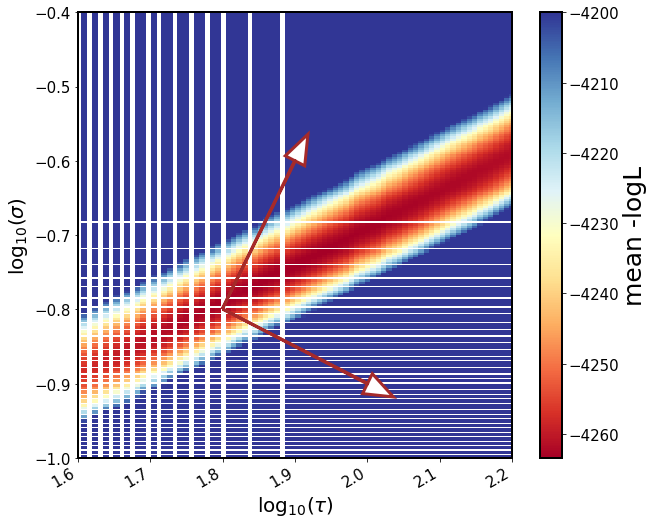

In [104]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = np.log10(z_tau.flatten())
y = np.log10(z_sigma.flatten())
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8.5,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\log_{10}(\tau)$')
ax.set_ylabel(r'$\log_{10}(\sigma)$')


# Why this does not produce perpendicular arrows ? ? ? ? ?? ? ? ? ?? ?  
# After all,   a in the second line is exactly  -1/a of the first one...
a = 2 
x1 = 1.8
y1 = -0.8
b = y1 - a * x1

x2 = 1.9 ;  y2 = a * x2 + b  
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy, fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

a = -0.5
b = y1 - a * x1

x2 = 2.0 ; y2 = a * x2 + b
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy,  fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

x0 = 1.6
y0 = -1.0
dx = 0.6
dy = dx 
ax.set_xlim(x0, x0+dx)
ax.set_ylim(y0, y0+dy)
plt.savefig(outDir+'sim_lc_log-log_K_sigma_hat_arrows.png', bbox_inches='tight')

So in theory,  along the diagonal in log(sigma) = log(tau) space is sigma_hat,   and perpendicular to that : K . 



But the problem is that if the scales (yrange, xrange) are not identical, then what is supposedly perpendicular, stops appearing to be so. 


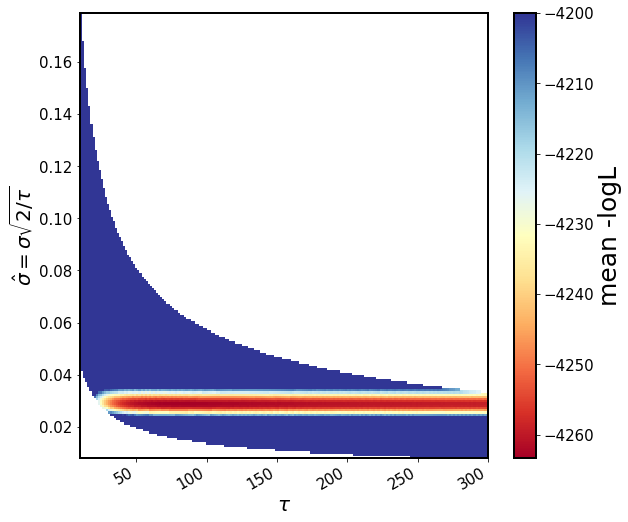

In [108]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_tau.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')

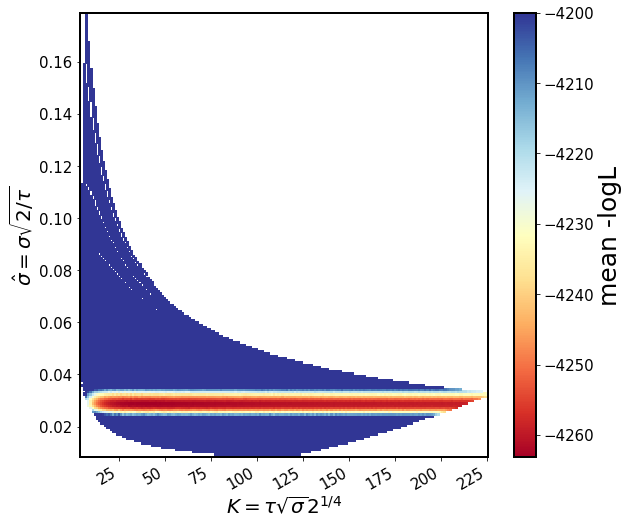

In [110]:
# Plot in space of sigma_hat  vs K  : 

# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_K.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')
ax.set_xlabel(r'$K = \tau \sqrt{\sigma} 2^{1/4}$')

Now this doesn't make sense, because I would expect K to be very well constrained and sigma_hat very poorly, whereas it is the other way round here ... 

array([[-307.45711654, -322.68947841, -335.37899517, ...,  138.13419937,
         141.1105474 ,  144.08318288],
       [-308.74976309, -323.80473204, -336.37317102, ...,  119.97631851,
         122.88775481,  125.79565809],
       [-309.86236767, -324.74829228, -337.2016207 , ...,  102.48144101,
         105.32969254,  108.17458525],
       ..., 
       [ -81.75201012,  -91.84584407, -101.22450773, ..., -393.09589443,
        -393.33982478, -393.58068142],
       [ -80.71550307,  -90.80730019, -100.18487729, ..., -392.67889402,
        -392.92590132, -393.16983231],
       [ -79.6821688 ,  -89.77195448,  -99.14845969, ..., -392.25870843,
        -392.50876217, -392.75573702]])

In [300]:
bounds

[(None, None), (None, None)]

In [301]:
initial_params

array([-3.21887582, -4.60517019])

In [303]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')

In [304]:
np.log(1/1)

0.0

In [305]:
np.log(1/1000)

-6.9077552789821368

In [309]:
2 * np.log(0.1)

-4.6051701859880909

In [310]:
bounds = [(-4.60517,  -2.40794  ), (- 6.9077, 0 )]

In [312]:
gp.get_parameter_bounds()

[(None, None), (None, None)]

In [313]:
gp.set_parameter?

In [322]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', -1.83258146374831),
             ('kernel:log_c', -5.7037824746562009)])

In [324]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')